In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests as rq
import pandas as pd

shootings_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=73c7e069-701f-4910-986d-b950f46c91a1&limit=10000"
shootings = pd.DataFrame((rq.get(url = shootings_URL)).json().get('result').get('records'))

In [ ]:
crime_incidents_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=b973d8cb-eeb2-4e7e-99da-c92938efc9c0&limit=5000000000"
crime_incidents = pd.DataFrame((rq.get(url = crime_incidents_URL)).json().get('result').get('records'))

In [ ]:
city_council_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=7918a624-2c23-493a-8d13-1c8fbd085e2d&limit=5000000000"
city_councils = pd.DataFrame((rq.get(url = city_council_URL)).json().get('result').get('records'))

In [ ]:
common_ids = set(shootings['_id']).intersection(set(crime_incidents['_id']))

In [ ]:
shootings = pd.merge(shootings, crime_incidents[['Long', 'Lat', '_id']], on='_id', how='inner')

In [ ]:
shootings.head(5)

,shooting_type_v2,victim_ethnicity_NIBRS,district,incident_num,victim_race,multi_victim,victim_gender,_id,shooting_date,Long,Lat
0,Non-Fatal,Not Hispanic or Latinx,C11,I152000196-00,Black or African American,f,Male,1,2015-01-01 13:30:00+00,-71.12883623098992,42.28630091783755
1,Non-Fatal,Not Hispanic or Latinx,E18,I152000879-00,Black or African American,f,Male,2,2015-01-04 01:58:00+00,-71.10429431787648,42.30971856767274
2,Non-Fatal,Not Hispanic or Latinx,E5,I152001014-00,Black or African American,f,Male,3,2015-01-04 18:52:00+00,-71.14822128377165,42.28709355259107
3,Non-Fatal,Not Hispanic or Latinx,B2,I152002232-00,Black or African American,t,Male,4,2015-01-08 22:45:00+00,None,None
4,Non-Fatal,Not Hispanic or Latinx,B2,I152002233-00,Black or African American,t,Female,5,2015-01-08 22:45:00+00,-71.05970910242573,42.29755532959655


## Community Center

In [ ]:
import pandas as pd

community_centers = pd.read_csv('/content/drive/MyDrive/Team 3/Deliverables/Proposal Deliverables/data/community_centers/community_centers_city_council.csv')

In [ ]:
from pyproj import Transformer

def point_to_coords(point_str):
    point_str = point_str.replace('POINT (', '').replace(')', '')
    x, y = point_str.split()
    transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
    lon, lat = transformer.transform(x, y)
    return lon, lat

community_centers[['long', 'lat']] = community_centers['geometry'].apply(lambda x: pd.Series(point_to_coords(x)))

print(community_centers.keys())

Index(['FID', 'OBJECTID', 'SITE', 'PHONE', 'FAX', 'STREET', 'NEIGH', 'ZIP',
       'geometry', 'city_council_id', 'long', 'lat'],
      dtype='object')


In [ ]:
shootings.dropna(inplace=True)
community_centers.dropna(inplace=True)

shootings['Lat'] = shootings['Lat'].apply(float)
shootings['Long'] = shootings['Long'].apply(float)

In [ ]:
shootings.shape

(1663, 11)

In [ ]:
from geopy import distance

black = 'Black or African American'
white = 'White'
asian = 'Asian'
unknown = 'Unknown'
male = 'Male'
female = 'Female'
single = 'f'
multiple = 't'
fatal = 'Fatal'
non_fatal = 'Non-Fatal'

def count_shootings_within_radius(center_lat, center_lon, radius, shootings):
    center = (center_lat, center_lon)
    count = 0
    num_black_victims = 0
    num_white_victims = 0
    num_asian_victms = 0
    num_unknown_victims = 0
    num_male_victims = 0
    num_female_victms = 0
    num_single_victims = 0
    num_multiple_victims = 0
    num_fatal_victims = 0
    num_non_fatal_victims = 0

    for _, shooting in shootings.iterrows():
        if shooting['considered']:
            continue
        lat, lon = shooting['Lat'], shooting['Long']
        dist = distance.distance(center, (lon, lat)).miles
        if dist <= radius:
            count += 1
            if shootings.at[shooting.name, 'victim_race'] == black:
              num_black_victims += 1
            elif shootings.at[shooting.name, 'victim_race'] == white:
              num_white_victims += 1
            elif shootings.at[shooting.name, 'victim_race'] == asian:
              num_asian_victms += 1
            elif shootings.at[shooting.name, 'victim_race'] == unknown:
              num_unknown_victims += 1

            if shootings.at[shooting.name, 'victim_gender'] == male:
              num_male_victims += 1
            elif shootings.at[shooting.name, 'victim_gender'] == female:
              num_female_victms += 1

            if shootings.at[shooting.name, 'multi_victim'] == single:
              num_single_victims += 1
            elif shootings.at[shooting.name, 'multi_victim'] == multiple:
              num_multiple_victims += 1

            if shootings.at[shooting.name, 'shooting_type_v2'] == fatal:
              num_fatal_victims += 1
            elif shootings.at[shooting.name, 'shooting_type_v2'] == non_fatal:
              num_non_fatal_victims += 1

            shootings.at[shooting.name, 'considered'] = True
    return pd.Series([count, num_black_victims, num_white_victims, num_asian_victms, num_unknown_victims, num_male_victims, num_female_victms, num_single_victims, num_multiple_victims, num_fatal_victims, num_non_fatal_victims])

radius = 1

shootings['considered'] = False
columns = ['num_shootings_within_radius', 'num_black_victims', 'num_white_victims', 'num_asian_victims', 'num_unknown_victims', 'num_male_victims', 'num_female_victims', 'num_single_victims', 'num_multiple_victims', 'num_fatal_victims', 'num_non_fatal_victims']
community_centers[columns] = community_centers.apply(lambda row: count_shootings_within_radius(row['lat'], row['long'], radius, shootings), axis=1)

In [ ]:
top_centers = community_centers.sort_values(by='num_shootings_within_radius', ascending=False).head(10).reset_index()

top_centers

,index,FID,OBJECTID,SITE,PHONE,FAX,STREET,NEIGH,ZIP,geometry,...,num_black_victims,num_white_victims,num_asian_victims,num_unknown_victims,num_male_victims,num_female_victims,num_single_victims,num_multiple_victims,num_fatal_victims,num_non_fatal_victims
0,10,11,0.0,Vine Street,635-1285,635-1291,339 Dudley Street,Roxbury,2119.0,POINT (-7912223.69585512 5210056.16249864),...,245,42,2,10,276,23,198,101,50,249
1,3,4,0.0,Golden Age Center,635-5175,635-5647,382 Main St.,Charlestown,2129.0,POINT (-7911466.95047821 5218037.85373099),...,205,32,0,7,214,30,172,72,41,203
2,6,7,0.0,Quincy*,635-5129,635-5132,885 Washington St,Boston,2111.0,POINT (-7910915.35743103 5213243.90221071),...,107,26,1,5,124,15,102,37,27,112
3,30,31,0.0,Jackson/Mann,635-5153,635-5275,500 Cambridge St.,Allston,2134.0,POINT (-7918990.36211811 5213991.00389212),...,86,12,1,7,93,13,82,24,21,85
4,12,13,0.0,Rec. Division @ Madison Park*,635-5206,635-5078,55 Malcom X Blvd,Roxbury,2119.0,POINT (-7913616.64722016 5210794.62348973),...,81,16,0,5,90,12,79,23,20,82
5,16,17,0.0,Holland*,635-5144,635-5152,85 Olney St.,Dorchester,2121.0,POINT (-7911879.08957177 5206948.65505094),...,79,17,0,4,82,18,74,26,15,85
6,1,2,0.0,Paris Street Pool*,635-1410,635-5079,113 Paris St.,East Boston,2128.0,POINT (-7907790.63566395 5216931.51518946),...,70,20,0,3,81,12,66,27,19,74
7,22,23,0.0,Hyde Park,635-5178,635-5290,1179 River St.,Hyde Park,2136.0,POINT (-7917152.63992229 5199468.43085871),...,72,14,0,2,81,7,58,30,7,81
8,4,5,0.0,Charlestown*,635-5169,635-5084,255 Medford St.,Charlestown,2129.0,POINT (-7910468.84935071 5218222.65423483),...,54,9,0,6,64,5,54,15,17,52
9,13,14,0.0,Tobin,635-5216,635-5288,1481 Tremont St.,Roxbury,2119.0,POINT (-7914611.15562509 5210902.42604632),...,54,13,1,1,61,8,52,17,10,59


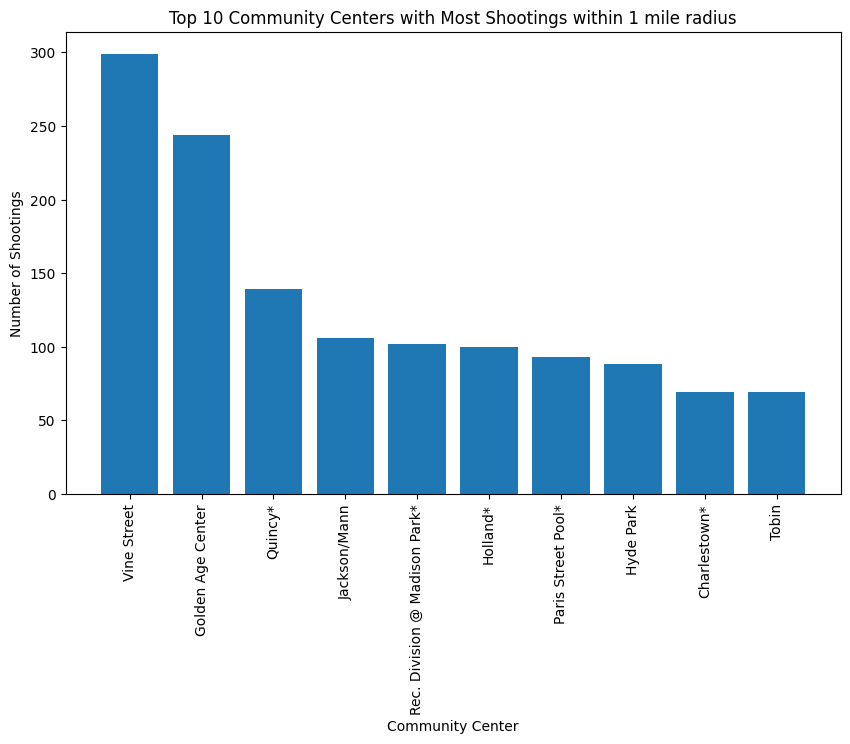

In [ ]:
import matplotlib.pyplot as plt

top_centers = community_centers.sort_values(by='num_shootings_within_radius', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x = top_centers['SITE'], height=top_centers['num_shootings_within_radius'])
ax.set_title('Top 10 Community Centers with Most Shootings within 1 mile radius')
ax.set_xlabel('Community Center')
ax.set_ylabel('Number of Shootings')
plt.xticks(rotation=90)
plt.show()

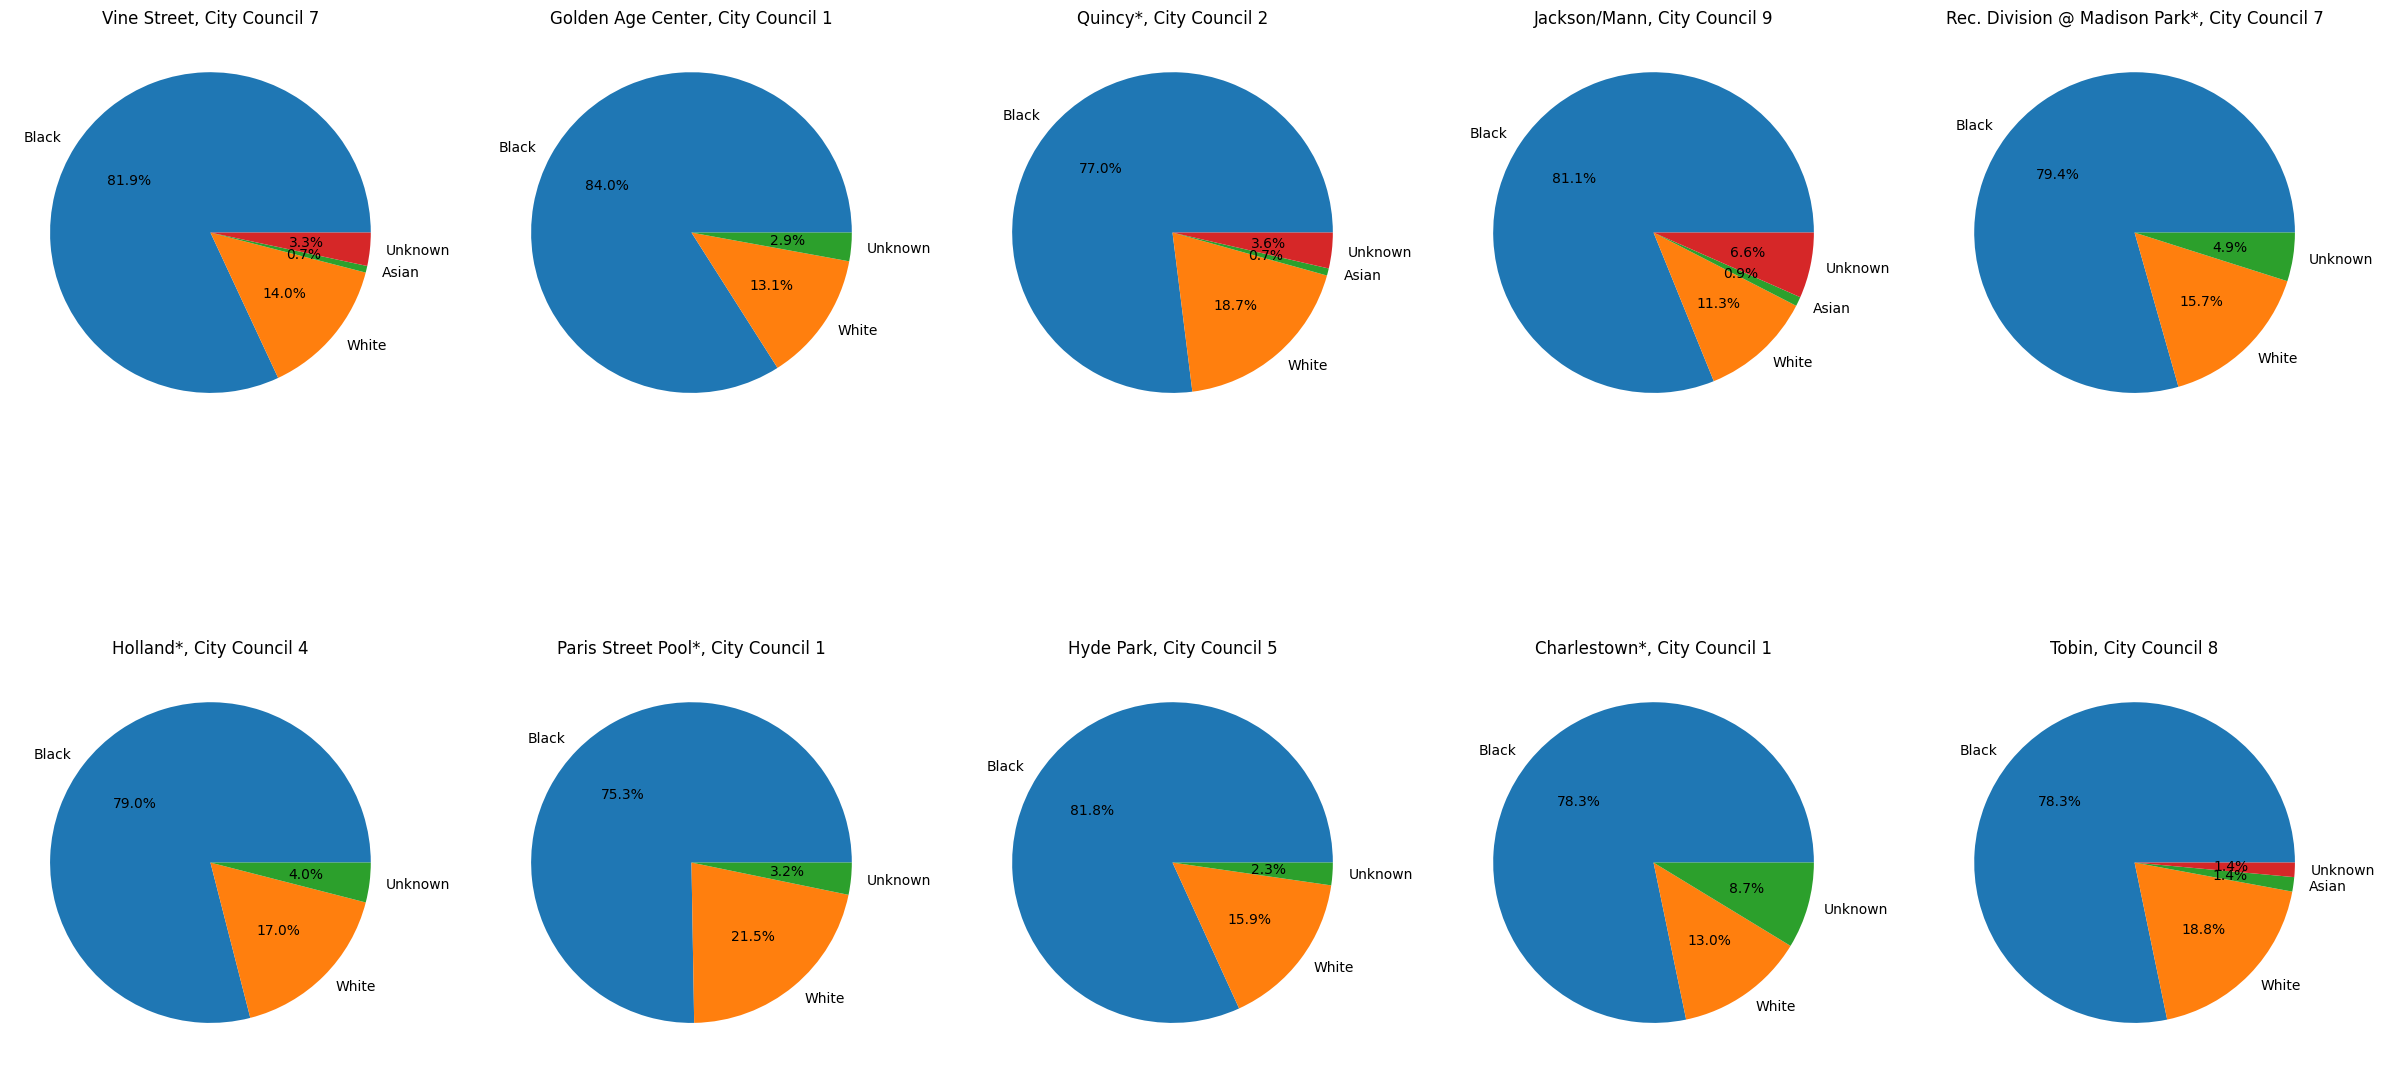

In [ ]:
labels = ['Black', 'White', 'Asian', 'Unknown']
fig, ax = plt.subplots(2, 5)
fig.set_figheight(15)
fig.set_figwidth(30)

for i in range(len(top_centers)):
    row = 0
    if i <=4:
        column = i
    else:
        column = i - 5

    if i >= 5:
        row = 1

    sizes = [top_centers.iloc[i]['num_black_victims'], top_centers.iloc[i]['num_white_victims'], top_centers.iloc[i]['num_asian_victims'], top_centers.iloc[i]['num_unknown_victims']]
    victim_labels = labels.copy()
    to_remove = False
    for j in range(len(sizes)):
        if sizes[j] == 0:
            victim_labels[j] = None
            to_remove = True
    if to_remove:
        new_victim_labels = [label for label in victim_labels if label is not None]
        sizes = [size for size in sizes if size != 0]
    else:
        new_victim_labels = victim_labels

    title = top_centers.iloc[i]['SITE'] + ", City Council " + str(top_centers.iloc[i]['city_council_id'])
    ax[row, column].pie(sizes, labels=new_victim_labels, autopct='%1.1f%%')
    ax[row, column].title.set_text(title)

plt.show()


Key Findings:

1. More shootings near Community Centers seem to happen in City Council 1, with 3 Community Centers each in the top 10 list.

2. There is only 1 Community Center from City Council 4 (Holland) in the top 10 list.

3. In every Community Center on the top 10 list, more than 75% of the victims are Black.

4. The Community Center at Paris Street Pool (City Council 1) has the highest number of White victims out of the Community Centers in the top 10 list at 21.5%. 

5. The Community Center at Jackson/Mann (City Council 9) has the highest number of victims of unknown ethnicity with 6.6%.

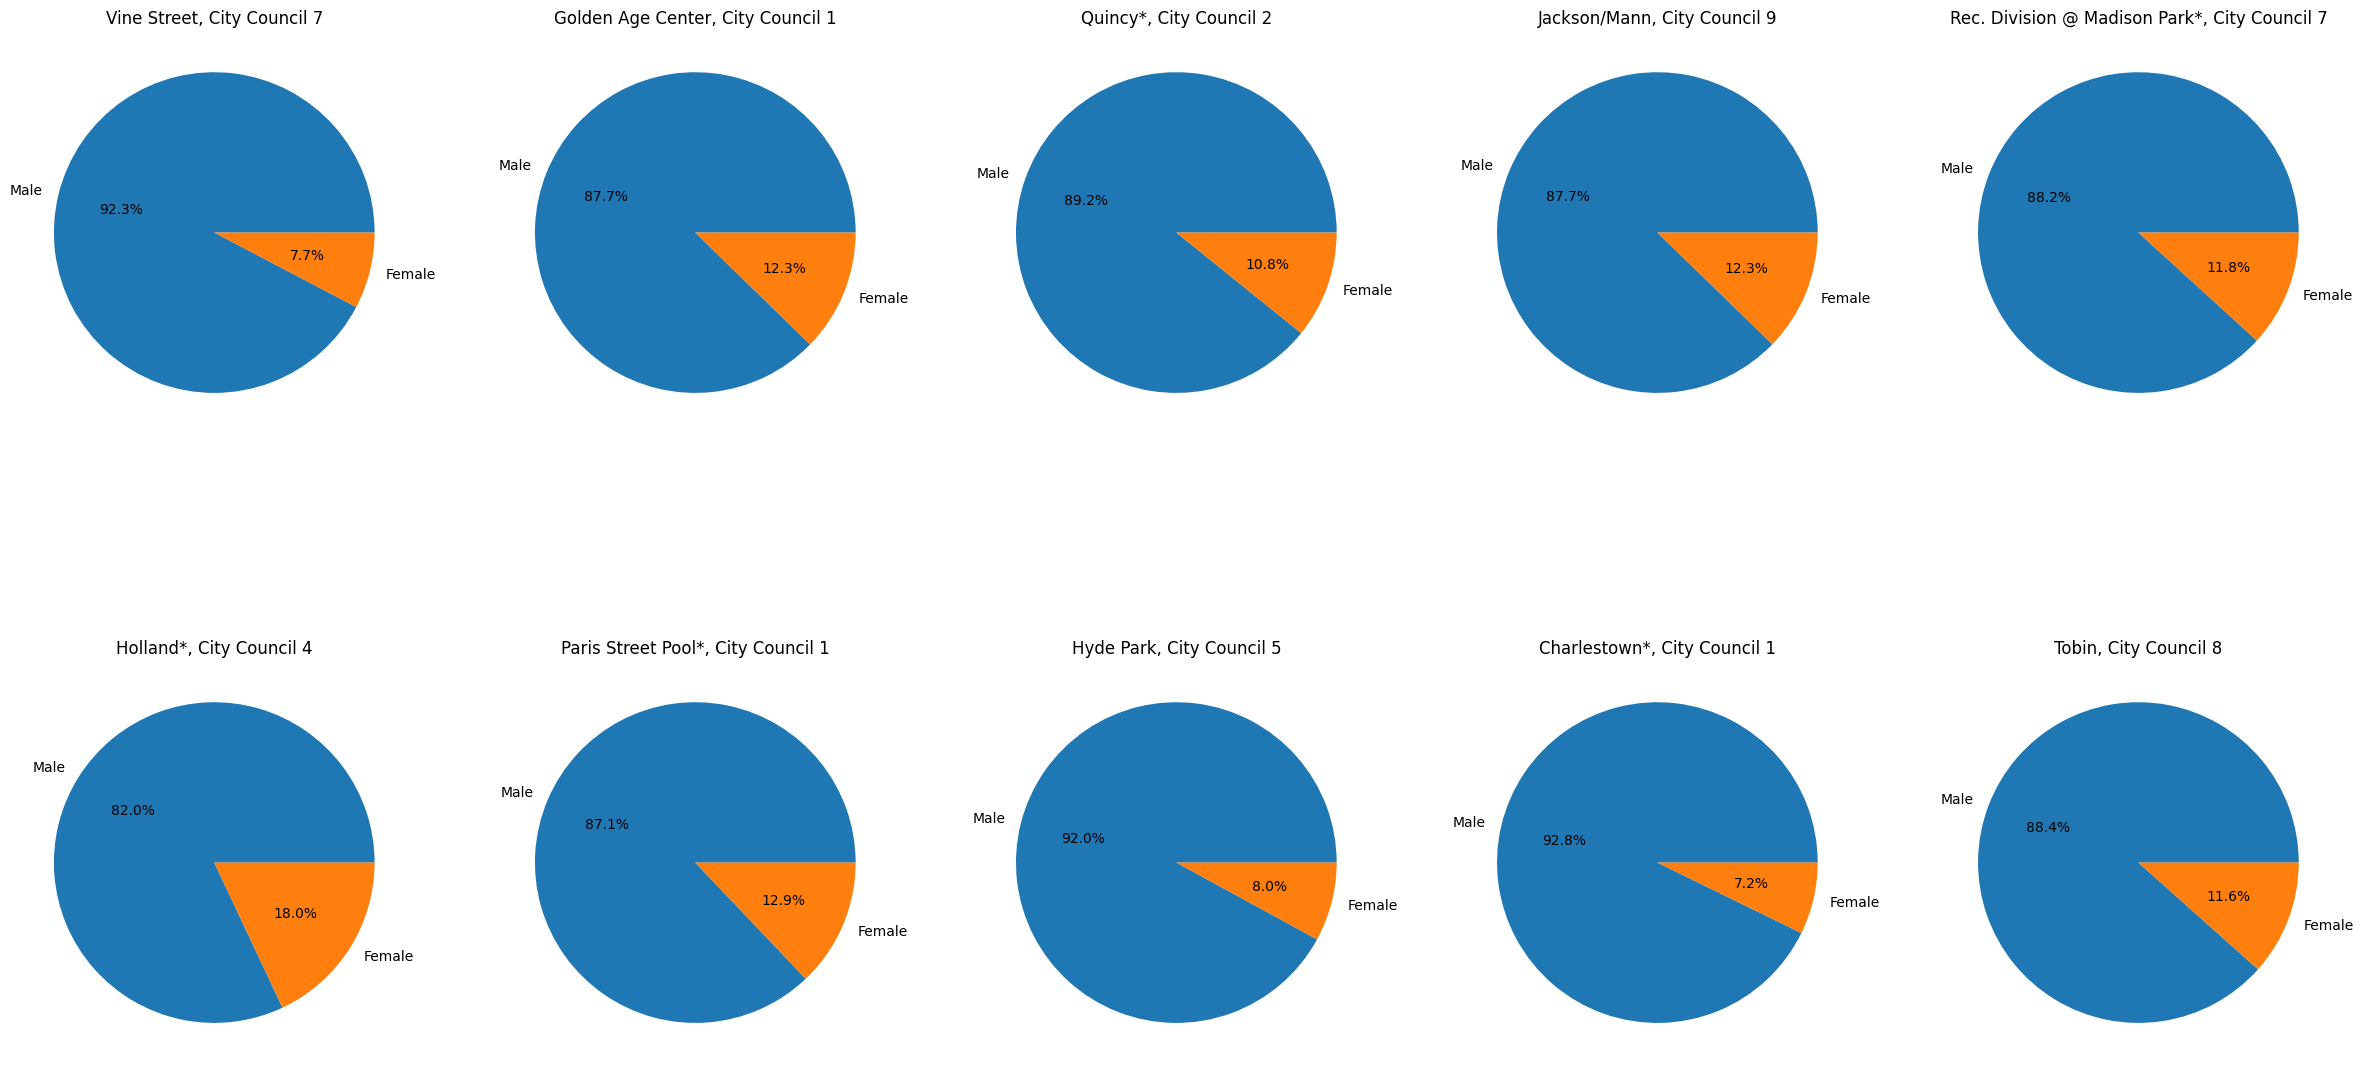

In [ ]:
labels = ['Male', 'Female']
fig, ax = plt.subplots(2, 5)
fig.set_figheight(15)
fig.set_figwidth(30)

for i in range(len(top_centers)):
  row = 0
  if i <=4:
    column = i
  else:
    column = i - 5

  if i >= 5:
    row = 1
  
  sizes = [top_centers.iloc[i]['num_male_victims'], top_centers.iloc[i]['num_female_victims']]
  victim_labels = labels.copy()
  to_remove = False
  for j in range(len(sizes)):
    if sizes[j] == 0:
      victim_labels.pop(j)
      to_remove = True
  if to_remove:
    new_victim_labels = [label for label in victim_labels if label is not None]
    sizes = [size for size in sizes if size != 0]
  else:
      new_victim_labels = victim_labels
  
  title = top_centers.iloc[i]['SITE'] + ", City Council " + str(top_centers.iloc[i]['city_council_id'])
  ax[row, column].pie(sizes, labels=victim_labels, autopct='%1.1f%%')
  ax[row, column].title.set_text(title)

plt.show()

Key Findings:

1. In all the Community Centers in the top 10 list, there are always more male victims than female victims (more than 80% of the victims are males in every case vs more than 7% for females).

2. Charlestown in City Council 1 has the highest percentage of male victims at 92.8%, whereas for females, it is at Holland in City Council 4, with 18%.

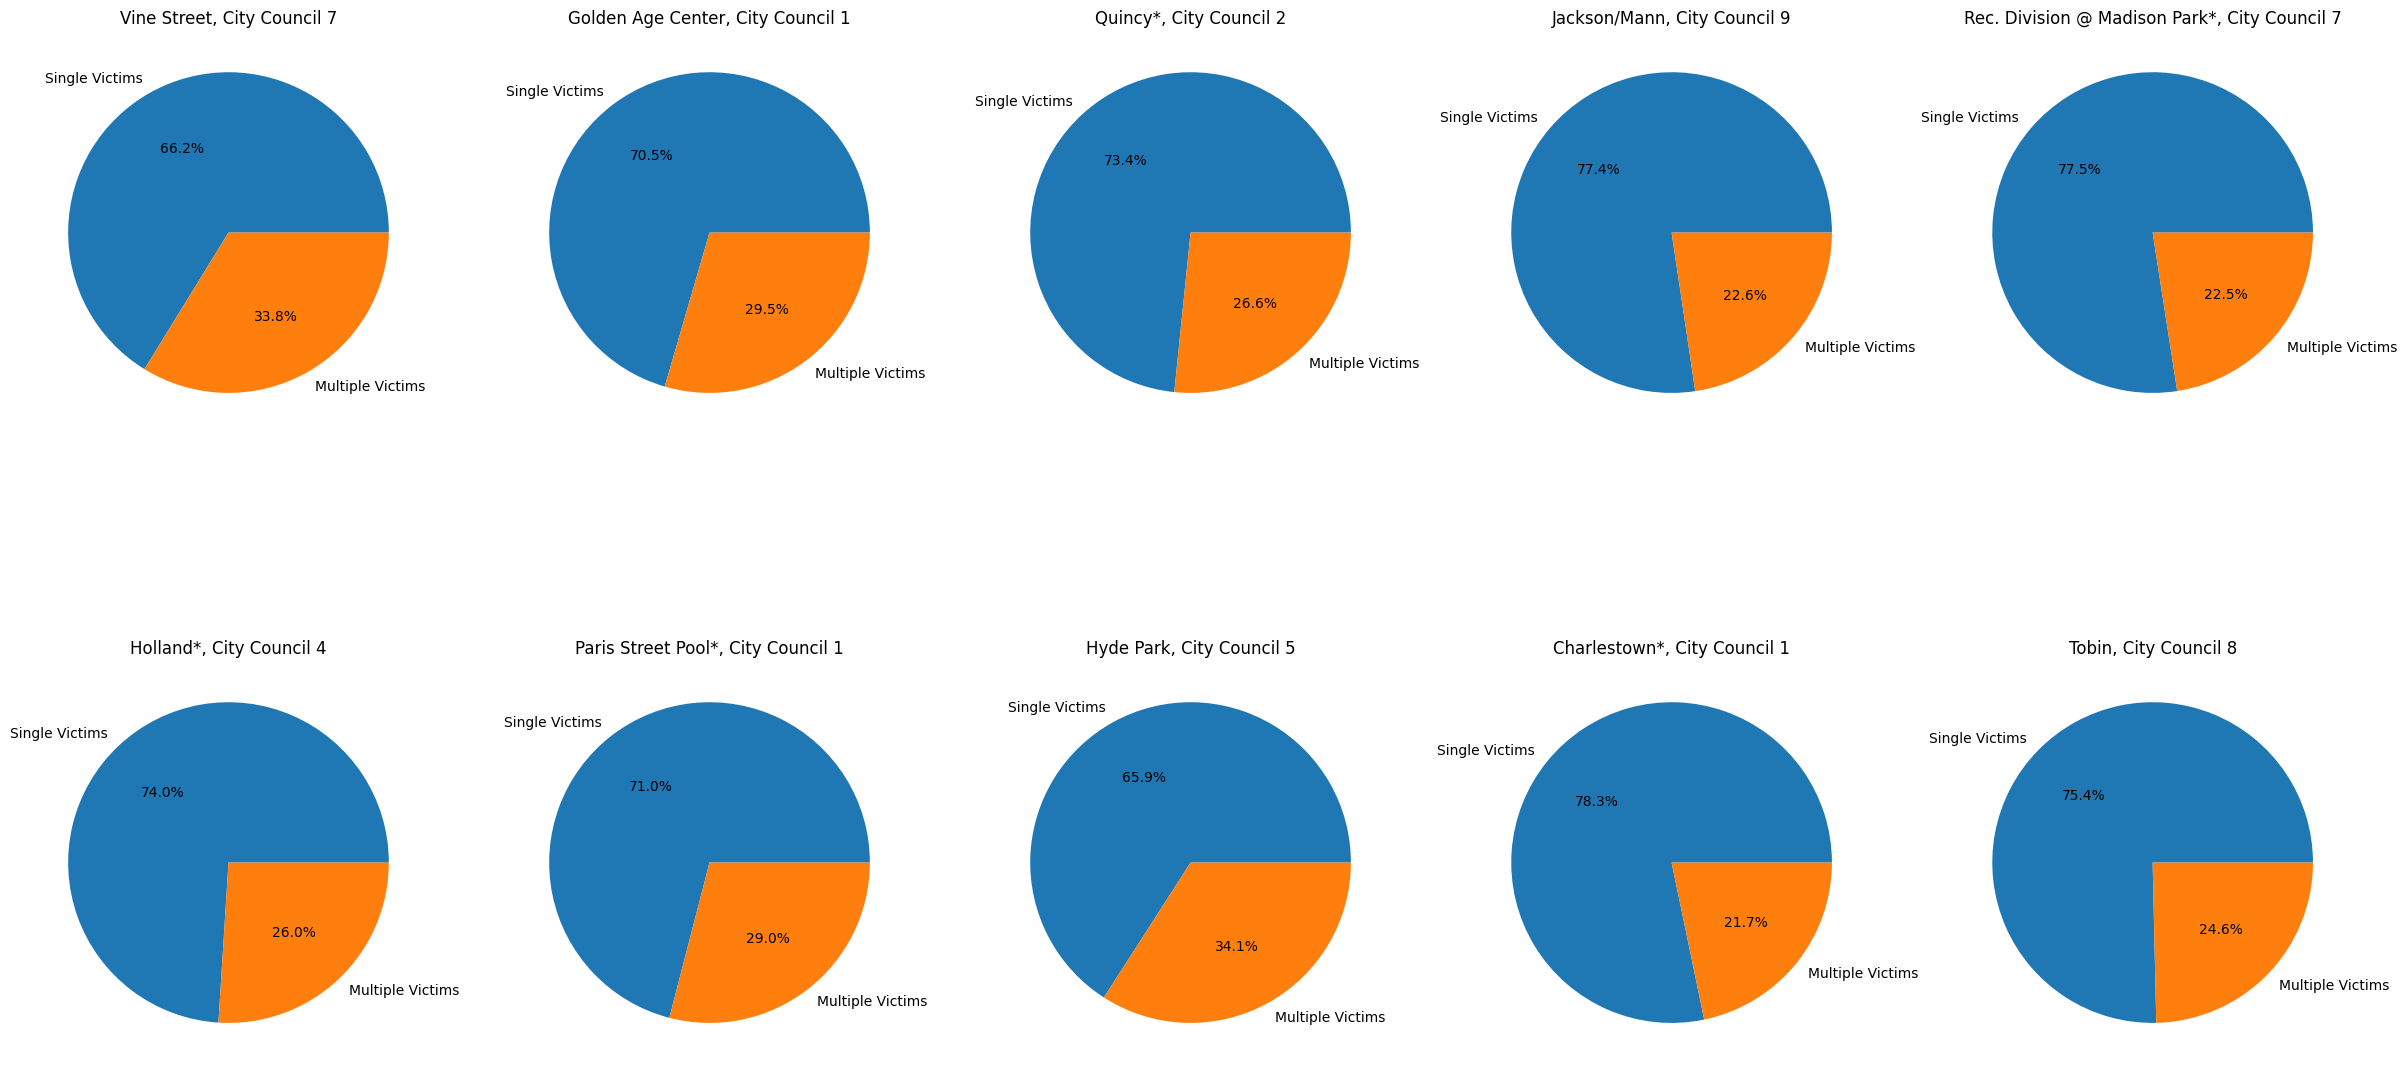

In [ ]:
labels = ['Single Victims', 'Multiple Victims']
fig, ax = plt.subplots(2, 5)
fig.set_figheight(15)
fig.set_figwidth(30)

for i in range(len(top_centers)):
  row = 0
  if i <=4:
    column = i
  else:
    column = i - 5

  if i >= 5:
    row = 1
  
  sizes = [top_centers.iloc[i]['num_single_victims'], top_centers.iloc[i]['num_multiple_victims']]
  victim_labels = labels.copy()
  to_remove = False
  for j in range(len(sizes)):
    if sizes[j] == 0:
      victim_labels.pop(j)
      to_remove = True
  if to_remove:
    new_victim_labels = [label for label in victim_labels if label is not None]
    sizes = [size for size in sizes if size != 0]
  else:
      new_victim_labels = victim_labels
  
  title = top_centers.iloc[i]['SITE'] + ", City Council " + str(top_centers.iloc[i]['city_council_id'])
  ax[row, column].pie(sizes, labels=victim_labels, autopct='%1.1f%%')
  ax[row, column].title.set_text(title)

plt.show()

Key Findings:

1. In all the Community Centers in the top 10 list, there are always more incidents with single victims than multiple victims (more than 60% of the incidents have a single victim in every case vs more than 21% for multiple victims).

2. Charlestown in City Council 1 has the highest percentage of incidents with a single victim at 78.3%, whereas for multiple victims, it is at Vine Street in City Council 7, with 33.8%.

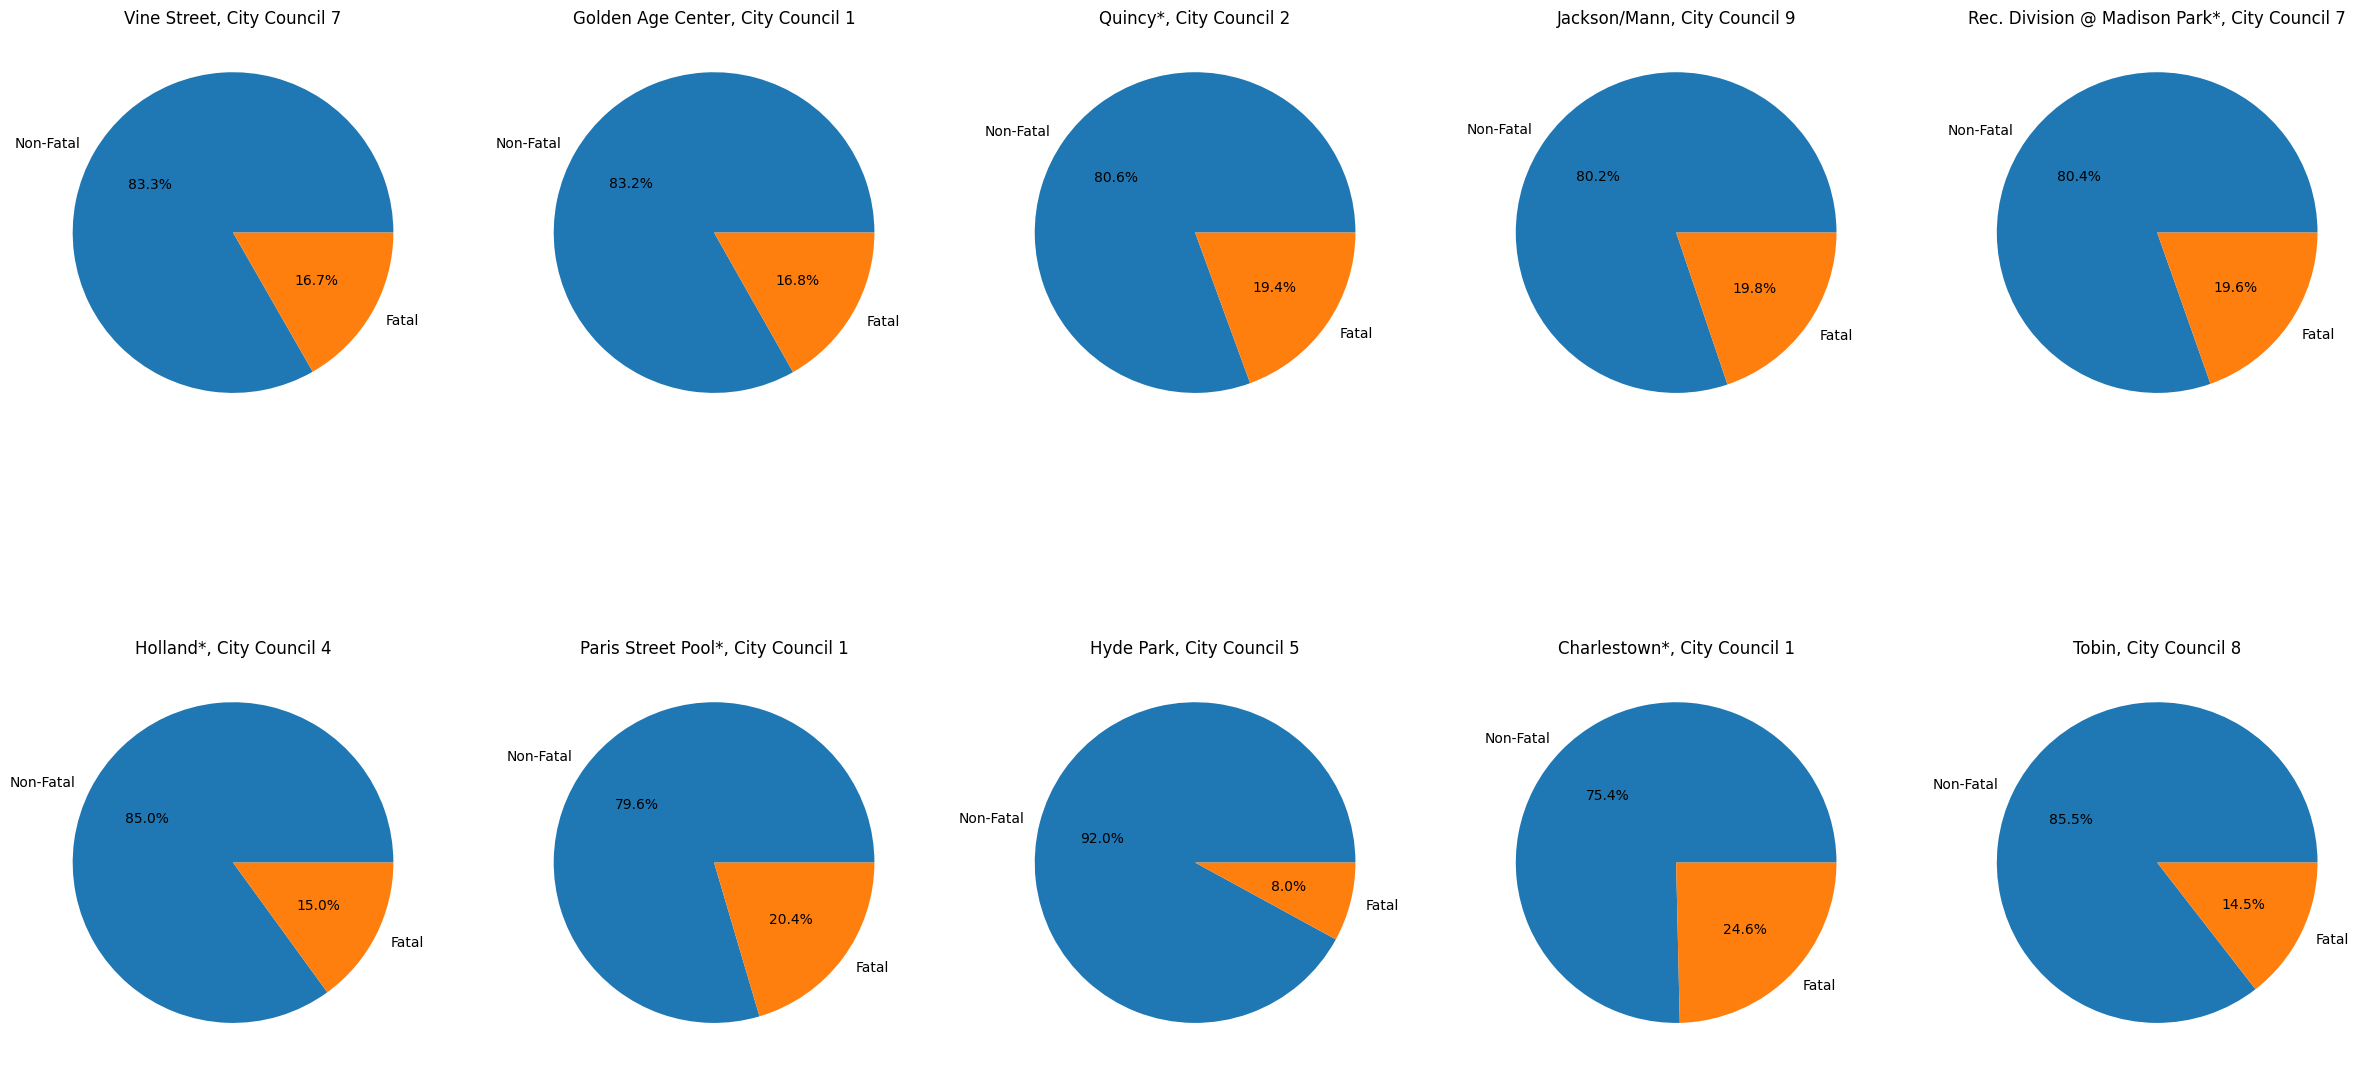

In [ ]:
labels = ['Non-Fatal', 'Fatal']
fig, ax = plt.subplots(2, 5)
fig.set_figheight(15)
fig.set_figwidth(30)

for i in range(len(top_centers)):
  row = 0
  if i <=4:
    column = i
  else:
    column = i - 5

  if i >= 5:
    row = 1
  
  sizes = [top_centers.iloc[i]['num_non_fatal_victims'], top_centers.iloc[i]['num_fatal_victims']]
  victim_labels = labels.copy()
  to_remove = False
  for j in range(len(sizes)):
    if sizes[j] == 0:
      victim_labels.pop(j)
      to_remove = True
  if to_remove:
    new_victim_labels = [label for label in victim_labels if label is not None]
    sizes = [size for size in sizes if size != 0]
  else:
      new_victim_labels = victim_labels
  
  title = top_centers.iloc[i]['SITE'] + ", City Council " + str(top_centers.iloc[i]['city_council_id'])
  ax[row, column].pie(sizes, labels=victim_labels, autopct='%1.1f%%')
  ax[row, column].title.set_text(title)

plt.show()

Key Findings:

1. In all the Community Centers in the top 10 list, there are always more non-fatal than fatal incidents (more than 75% of the incidents are non-fatal in every case vs more than 14% for fatal ones).

2. Hyde Park in City Council 5 has the highest percentage of male victims at 92%, whereas for fatal ones, it is at Charlestown in City Council 1, with 24.6%.

District 4 Community Centers

In [ ]:
community_centers_district_4 = community_centers.loc[community_centers['city_council_id']==4]
community_centers_district_4 = community_centers_district_4.drop(community_centers_district_4.loc[community_centers_district_4['FID'] == 34].index) # Grove Hall has no recorded count of victims

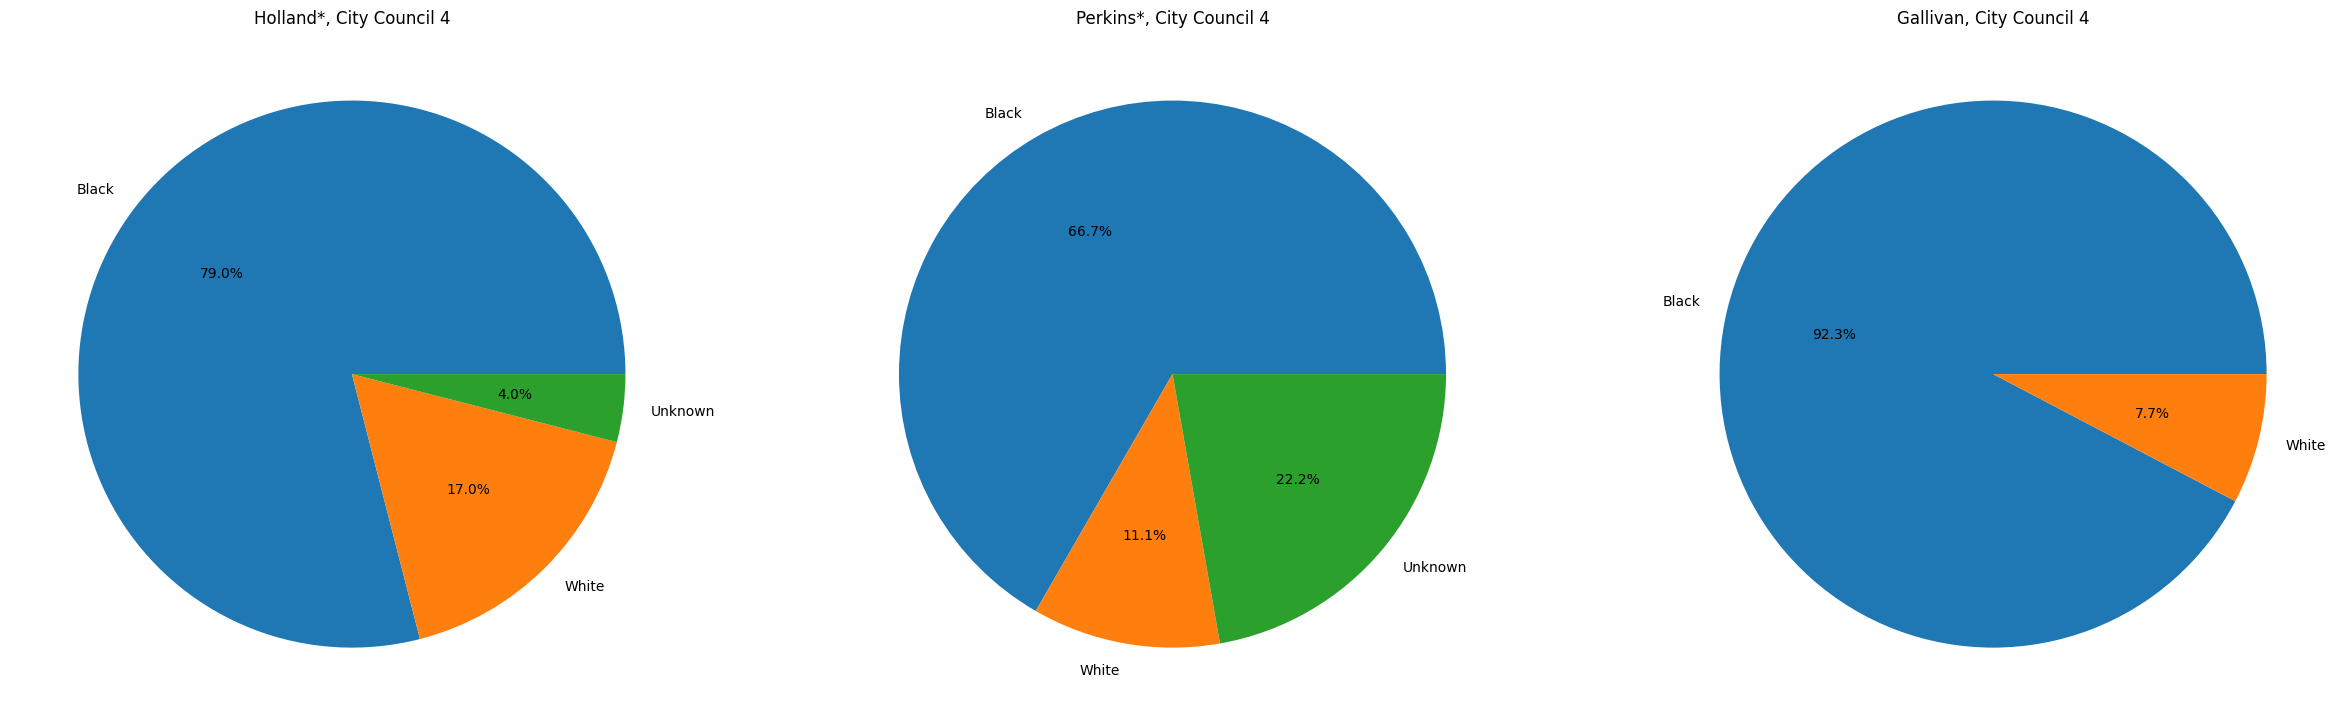

In [ ]:
labels = ['Black', 'White', 'Asian', 'Unknown']
fig, ax = plt.subplots(1, 3)
fig.set_figheight(15)
fig.set_figwidth(30)

for i in range(len(community_centers_district_4)):
    sizes = [community_centers_district_4.iloc[i]['num_black_victims'], community_centers_district_4.iloc[i]['num_white_victims'], community_centers_district_4.iloc[i]['num_asian_victims'], community_centers_district_4.iloc[i]['num_unknown_victims']]
    victim_labels = labels.copy()
    to_remove = False
    for j in range(len(sizes)):
        if sizes[j] == 0:
            victim_labels[j] = None
            to_remove = True
    if to_remove:
        new_victim_labels = [label for label in victim_labels if label is not None]
        sizes = [size for size in sizes if size != 0]
    else:
        new_victim_labels = victim_labels

    title = community_centers_district_4.iloc[i]['SITE'] + ", City Council " + str(community_centers_district_4.iloc[i]['city_council_id'])
    ax[i].pie(sizes, labels=new_victim_labels, autopct='%1.1f%%')
    ax[i].title.set_text(title)

plt.show()


Key Findings:
* For the top 3 community centers in D4 We see that the majority race that is effected are black
* White and the rest of unknown races combined at most have 1/3 the amount of gun violence incidents while the rest is black
* These community centers are located in predominatly black neighborhoods so our graphs represent those biases

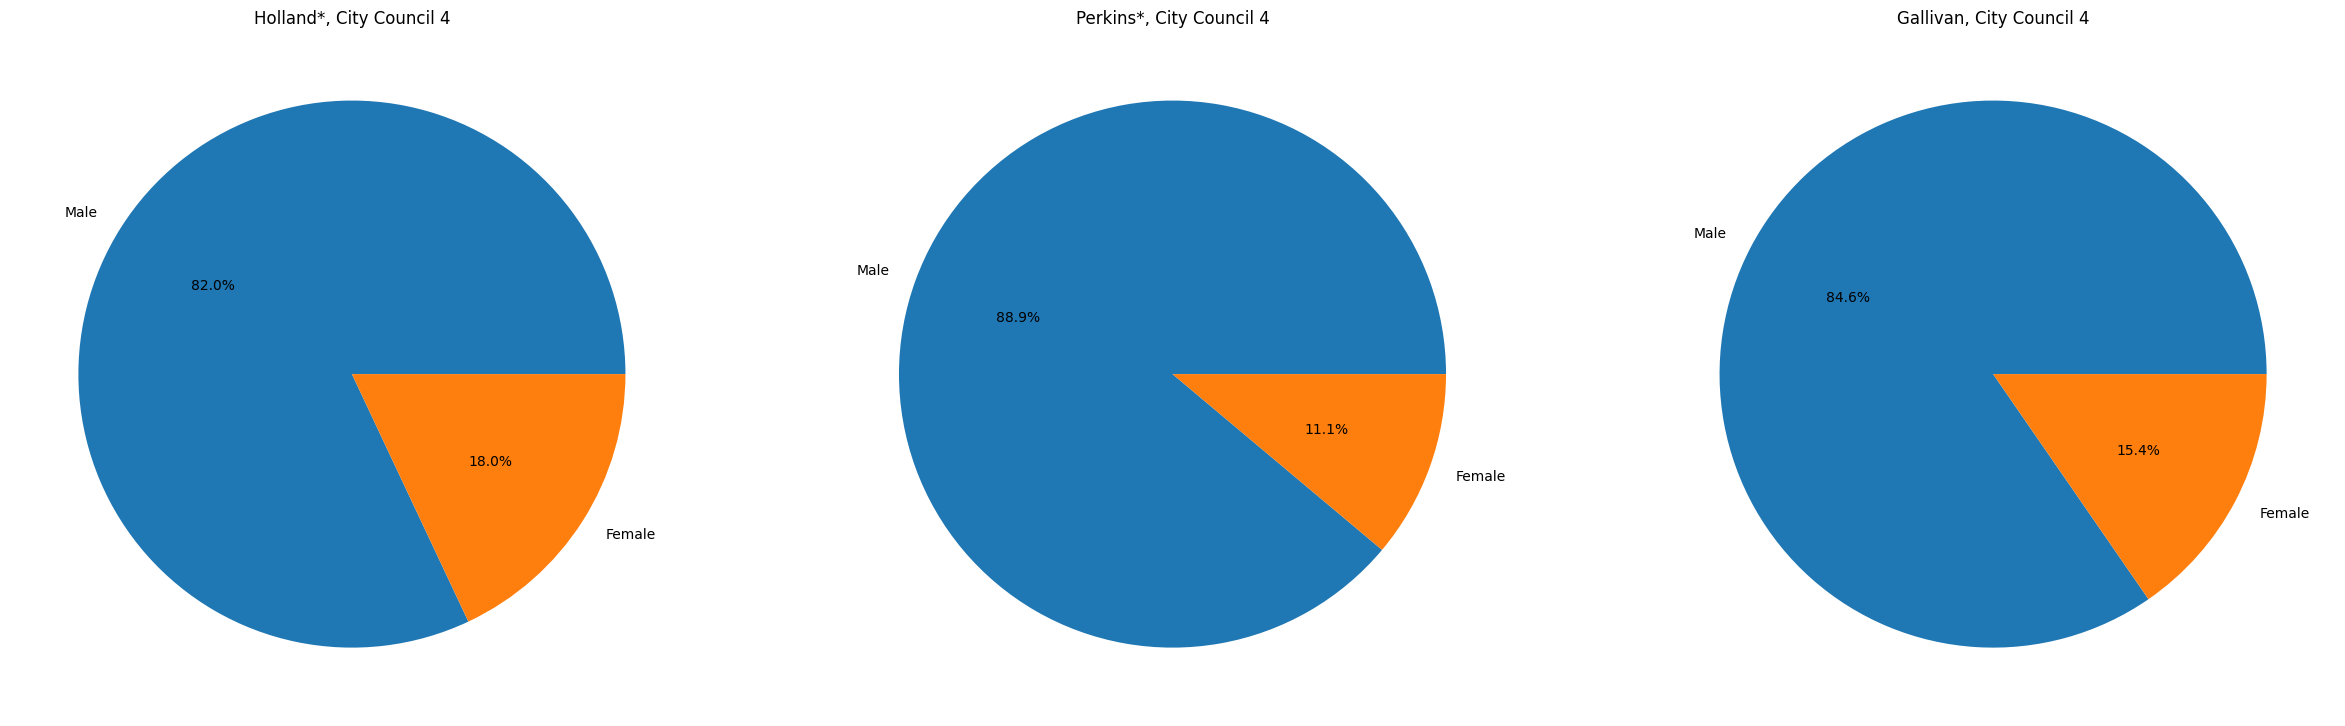

In [ ]:
labels = ['Male', 'Female']
fig, ax = plt.subplots(1, 3)
fig.set_figheight(15)
fig.set_figwidth(30)

for i in range(len(community_centers_district_4)):
  sizes = [community_centers_district_4.iloc[i]['num_male_victims'], community_centers_district_4.iloc[i]['num_female_victims']]
  victim_labels = labels.copy()
  to_remove = False
  for j in range(len(sizes)):
    if sizes[j] == 0:
      victim_labels.pop(j)
      to_remove = True
  if to_remove:
    new_victim_labels = [label for label in victim_labels if label is not None]
    sizes = [size for size in sizes if size != 0]
  else:
      new_victim_labels = victim_labels
  
  title = community_centers_district_4.iloc[i]['SITE'] + ", City Council " + str(community_centers_district_4.iloc[i]['city_council_id'])
  ax[i].pie(sizes, labels=victim_labels, autopct='%1.1f%%')
  ax[i].title.set_text(title)

plt.show()

Key Findings:
* For the top 3 community centers in D4 We see that male victims outnumber female victims by 4 to 1.
* Generally, its considered that men perpetrate more gun violence than women (due to sociological properties) so seeing men victims also high is interesting

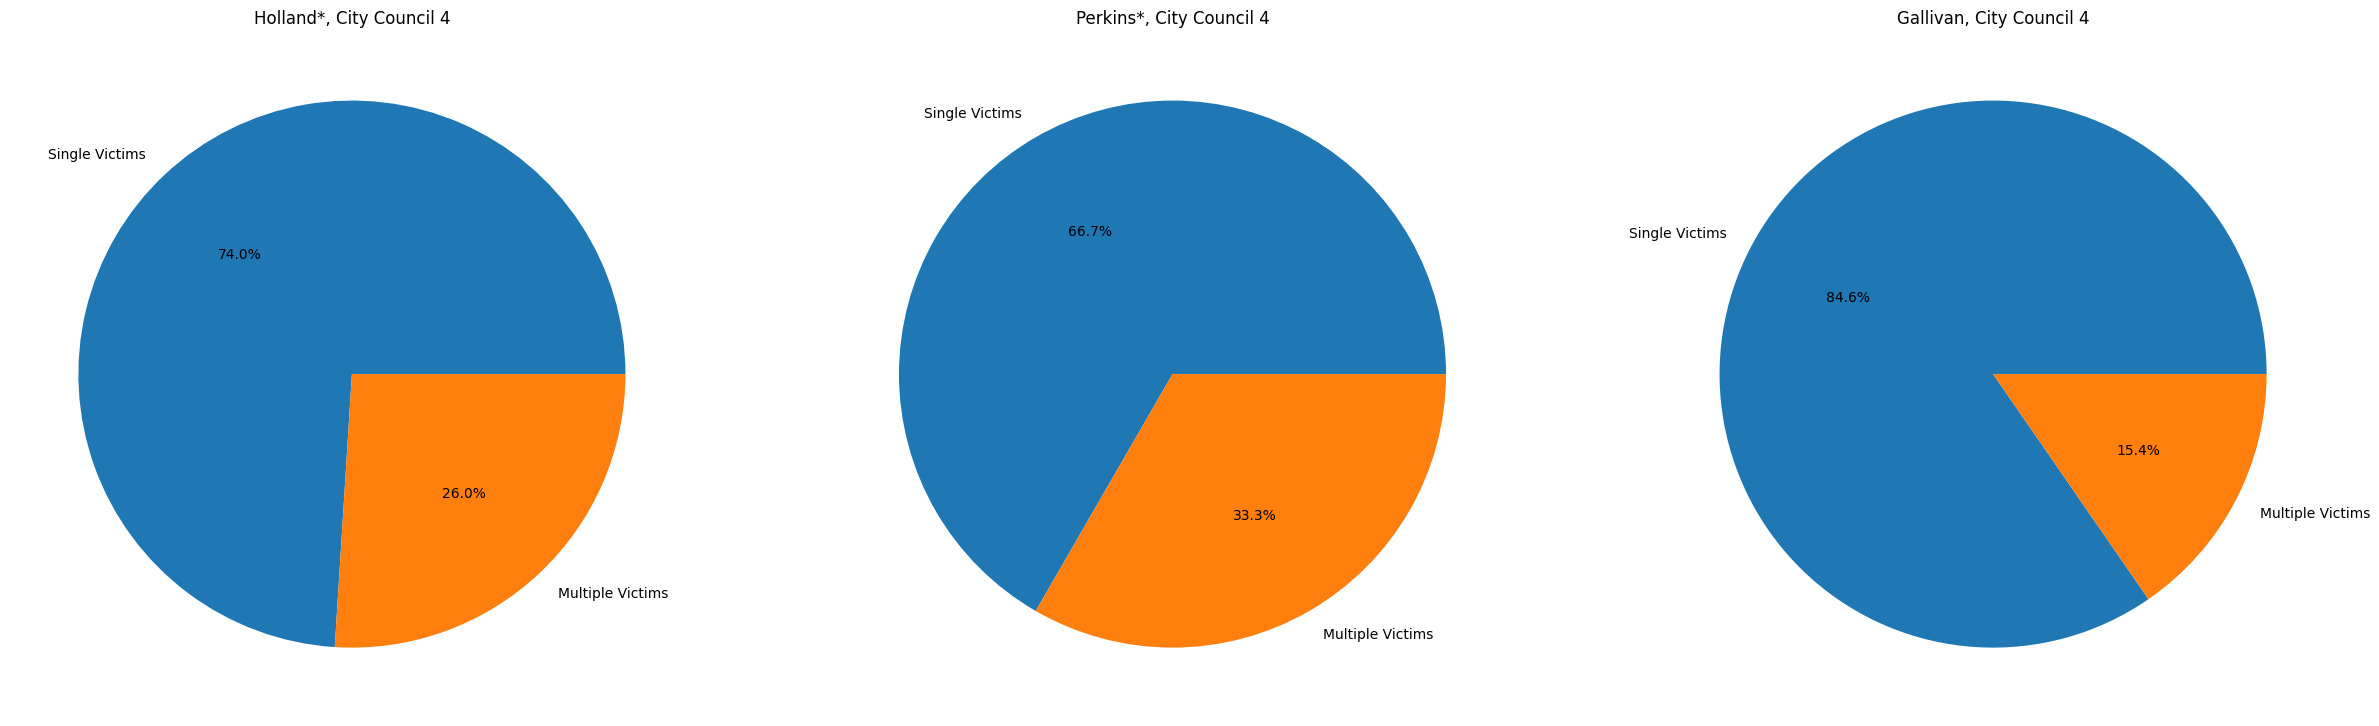

In [ ]:
labels = ['Single Victims', 'Multiple Victims']
fig, ax = plt.subplots(1, 3)
fig.set_figheight(15)
fig.set_figwidth(30)

for i in range(len(community_centers_district_4)):
  sizes = [community_centers_district_4.iloc[i]['num_single_victims'], community_centers_district_4.iloc[i]['num_multiple_victims']]
  victim_labels = labels.copy()
  to_remove = False
  for j in range(len(sizes)):
    if sizes[j] == 0:
      victim_labels.pop(j)
      to_remove = True
  if to_remove:
    new_victim_labels = [label for label in victim_labels if label is not None]
    sizes = [size for size in sizes if size != 0]
  else:
      new_victim_labels = victim_labels
  
  title = community_centers_district_4.iloc[i]['SITE'] + ", City Council " + str(community_centers_district_4.iloc[i]['city_council_id'])
  ax[i].pie(sizes, labels=victim_labels, autopct='%1.1f%%')
  ax[i].title.set_text(title)

plt.show()

Key Findings:
* For the top 3 community centers in D4 Single Victims outnumber Multiple Victims almost 4 to 1
* Community centers are a public place with lots of people so its interesting that multiple victims are less than single. This could highlight a bias in our data where we get a range of incidents near the community center within one mile


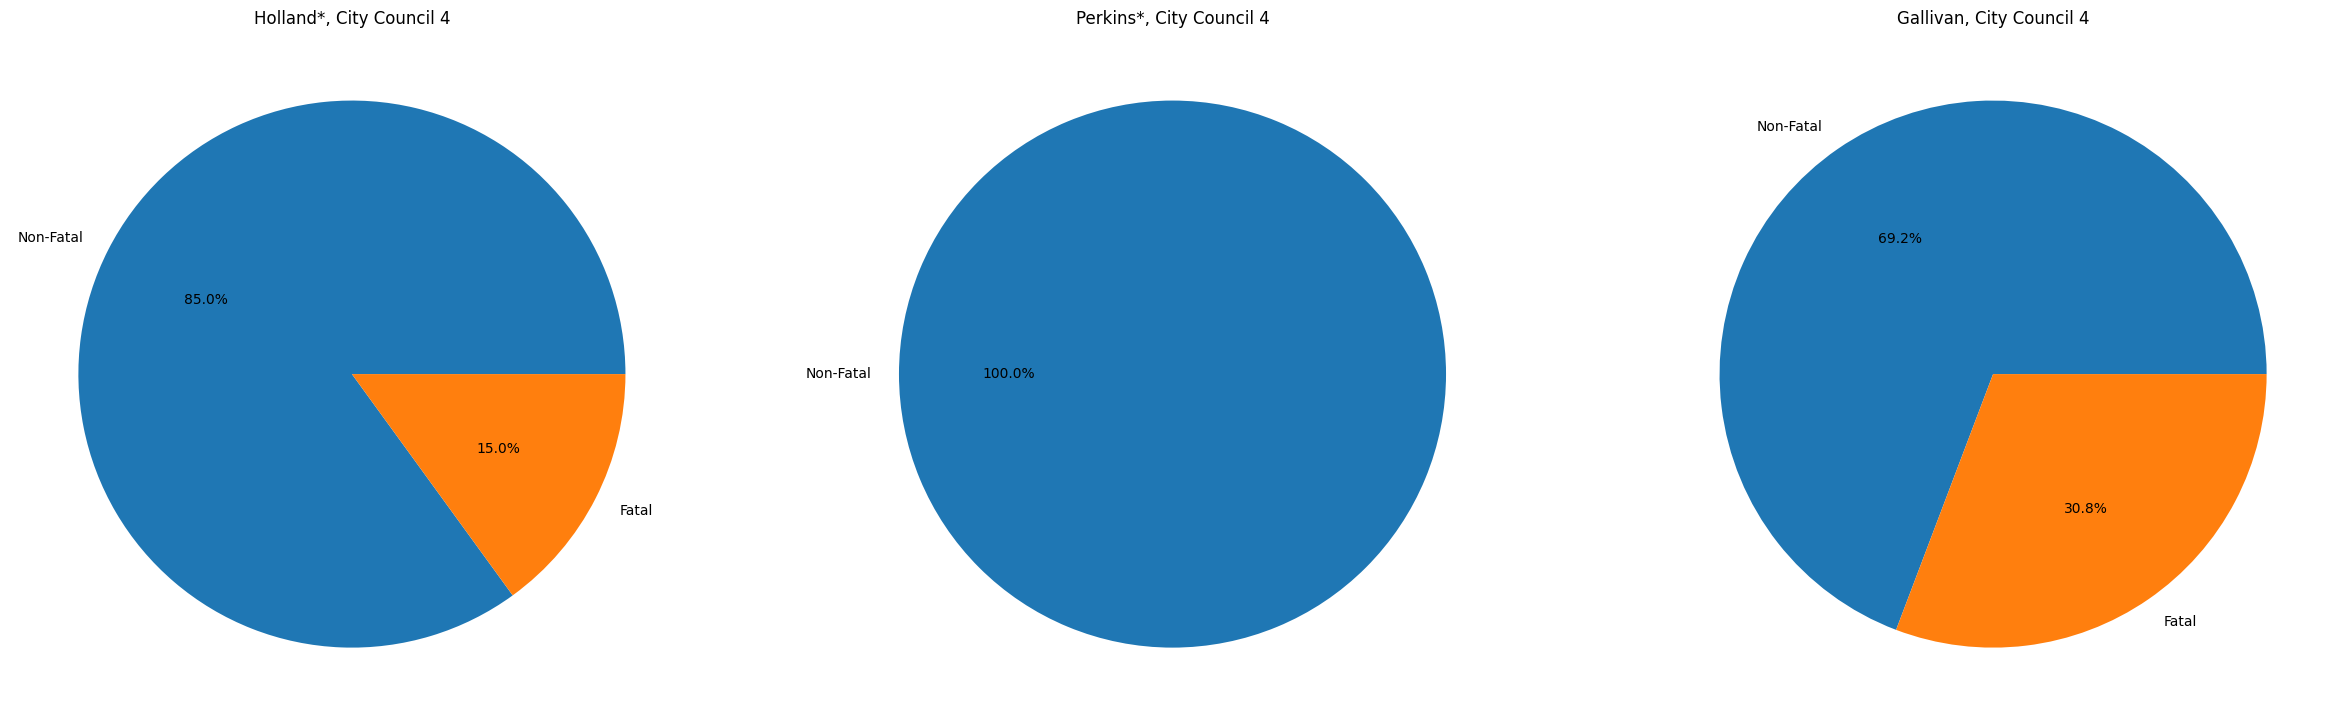

In [ ]:
labels = ['Non-Fatal', 'Fatal']
fig, ax = plt.subplots(1, 3)
fig.set_figheight(15)
fig.set_figwidth(30)

for i in range(len(community_centers_district_4)):
  sizes = [community_centers_district_4.iloc[i]['num_non_fatal_victims'], community_centers_district_4.iloc[i]['num_fatal_victims']]
  victim_labels = labels.copy()
  to_remove = False
  for j in range(len(sizes)):
    if sizes[j] == 0:
      victim_labels.pop(j)
      to_remove = True
  if to_remove:
    new_victim_labels = [label for label in victim_labels if label is not None]
    sizes = [size for size in sizes if size != 0]
  else:
      new_victim_labels = victim_labels
  
  title = community_centers_district_4.iloc[i]['SITE'] + ", City Council " + str(community_centers_district_4.iloc[i]['city_council_id'])
  ax[i].pie(sizes, labels=victim_labels, autopct='%1.1f%%')
  ax[i].title.set_text(title)

plt.show()

Key Findings:
* For the top 3 community centers in D4 Non fatal incidents happen on average 85% and fatal incidents happen 15% 
* On average most shootings have more non-fatal vs fatal but its still interesting to note the same trend happening on a local level
